## 1. Import libraries

In [1]:
import pandas as pd
import os,pickle,datetime
import numpy as np
import math
from math import pi
from sqlalchemy import create_engine
# !pip install psycopg2
import psycopg2

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb 

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (r2_score, accuracy_score, mean_squared_error, median_absolute_error)

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# plt.rcParams['figure.figsize'] = [6, 2]

%matplotlib inline

## 2. Importing csv file into a postgres database
### Steps
- import the csv file into a pandas dataframe
- Check the datatypes
- Check if need to clean the features' names
- Check the categorical features unique value, see if need to: 
    - clean and remove extra symbols, spaces, capital letters, etc.
- write the create table sql statement
- import the data into the db

In [2]:
df = pd.read_csv(r"price.csv")
print(df.shape)
df.head()

(10000, 8)


,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [3]:
df.dtypes

loc1      object
loc2      object
para1      int64
dow       object
para2      int64
para3    float64
para4    float64
price    float64
dtype: object

In [4]:
df.isnull().sum().sum()

0

In [5]:
df[['loc1','loc2','dow']].describe()

,loc1,loc2,dow
count,10000,10000,10000
unique,12,107,7
top,2,21,Wed
freq,1607,499,2233


In [6]:
df.dow.unique()

array(['Mon', 'Thu', 'Tue', 'Wed', 'Fri', 'Sat', 'Sun'], dtype=object)

In [7]:
df.loc1.unique()

array(['0', '9', '4', '5', '7', '8', '1', '3', '2', '6', 'S', 'T'],
      dtype=object)

In [8]:
df.loc2.unique()

array(['01', '99', '04', '40', '50', '03', '09', '74', '89', '17', '34',
       '30', '21', '59', '28', '64', '14', '46', '19', '15', '90', '67',
       '85', '24', '12', '20', '23', '08', '06', '95', '37', '77', '73',
       '88', '66', '39', '41', '68', '47', '33', '35', '78', '54', '76',
       '51', '79', '16', '02', '29', '57', '45', '80', '31', '70', '22',
       '27', '87', '53', '75', '38', '26', '25', '63', '86', '97', '81',
       '13', '49', '32', '72', '71', '10', '94', '96', '93', '42', '48',
       '55', '91', '58', '60', '44', '52', '05', '36', '82', '56', '84',
       '65', '07', '92', '83', '18', '69', '98', '62', '00', '61', '0B',
       'S6', '43', '0T', 'TS', '0L', '11', '0C', '0N'], dtype=object)

In [9]:
df.para1.unique()

array([  1,   0,   4,   3,   2,   5,  24,   7,   6,  13,   9,   8, 337],
      dtype=int64)

In [10]:
df.para2.unique()

array([ 662,  340,   16, ...,   41, 1490,  880], dtype=int64)

##### All the feature names look fine, no missing values, and the categorical features' value didn't contain any special charaters/white space.

### 2.1 Mapping the data types
- Replace dataframe's data types with postgresql's data types

In [11]:
replacements = {
    'object': 'varchar',
    'int64': 'int',
    'float64': 'float'
}

# using the join to join the col name with the data type
# {col name} {data type}
col_str = ", ".join("{0} {1}".format(n,d) for (n,d) in zip(df.columns, df.dtypes.replace(replacements)))

col_str

'loc1 varchar, loc2 varchar, para1 int, dow varchar, para2 int, para3 float, para4 float, price float'

### 2.2 Create db connection, copy and upload data to postgreSQL database 

In [12]:
def upload_to_db(host_name, dbname, user, password, tbl_name, col_str, file, dataframe, dataframe_columns):

    conn_string = "host=%s dbname=%s user=%s password=%s" % (host_name, dbname, user, password)
    conn = psycopg2.connect(conn_string)
    cursor = conn.cursor()
    print('Database opened successfully')
    
    # Drop table if it exists 
    cursor.execute("drop table if exists %s;" % (tbl_name))

    #create table
    cursor.execute("create table %s (%s);" % (tbl_name, col_str))
    print('Table {0} was created successfully'.format(tbl_name)) 
    
    #insert values to table

    #save df to csv
    dataframe.to_csv(file, header=dataframe_columns, index=False, encoding='utf-8')

    #open the csv file, save it as an object
    my_file = open(file)
    print('File opened successfully')
    
    #upload to db
    SQL_STATEMENT = """
    COPY %s FROM STDIN WITH
        CSV
        HEADER
        DELIMITER AS ','
    """

    cursor.copy_expert(sql=SQL_STATEMENT % tbl_name, file=my_file)
    print('File copied to database successfully')
    
    cursor.execute("grant select on table %s to public" % tbl_name)
    conn.commit()
    cursor.close()
    print('Table {0} imported to database completed'.format(tbl_name))

    return

## 3. EDA
### Steps
- Quickly browse the dataframe
- Check the duplicates
- Check the numerical features basic stats
- Basic visualizations (outliers, distribution, frequency etc)
- Dependent feature vs independent features relationship
- Correlation

In [13]:
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [14]:
print("Total number of duplicates in the dataset is: {}".format(df.duplicated().sum()))

Total number of duplicates in the dataset is: 107


In [15]:
# take a look at the duplicated rows
df[df.duplicated()].sort_values(by=['loc1']).reset_index(drop=True)

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,06,1,Wed,332,10000.0,7.0,175.0
1,0,06,1,Wed,247,16000.0,13.6,550.0
2,0,06,3,Fri,333,22000.0,13.6,270.0
3,0,06,3,Fri,333,22000.0,13.6,270.0
4,0,03,0,Tue,114,20000.0,13.6,200.0
...,...,...,...,...,...,...,...,...
102,8,89,1,Thu,554,24000.0,13.6,400.0
103,8,89,1,Thu,554,24000.0,13.6,400.0
104,8,89,1,Tue,554,24000.0,13.6,400.0
105,8,89,1,Tue,554,24000.0,13.6,400.0


In [16]:
df.para1.unique()

array([  1,   0,   4,   3,   2,   5,  24,   7,   6,  13,   9,   8, 337],
      dtype=int64)

In [17]:
df.para2.unique()

array([ 662,  340,   16, ...,   41, 1490,  880], dtype=int64)

In [18]:
df.para3.unique()

array([3000., 2760., 2700., ...,  957., 8856.,  336.])

In [19]:
df.para4.unique()

array([ 3.8 ,  9.2 ,  3.  ,  6.4 , 10.8 , 13.6 ,  4.5 , 13.2 ,  6.  ,
        2.7 ,  5.  ,  6.8 ,  5.2 ,  4.  ,  4.8 ,  5.1 ,  1.6 ,  8.8 ,
       12.8 ,  5.6 ,  2.67,  2.8 ,  5.5 , 11.2 ,  7.  , 11.6 ,  4.4 ,
        5.25,  4.6 ,  8.  , 12.  ,  4.3 ,  3.6 ,  2.5 , 10.  , 15.4 ,
        4.53,  3.3 ,  1.  ,  9.6 ,  7.6 ,  2.  ,  3.2 ,  2.4 ,  3.5 ,
        5.4 ,  1.2 ,  2.1 , 10.4 ,  6.5 , 13.5 ,  3.4 ,  1.5 , 14.  ,
        9.  ,  1.1 ,  5.9 ,  8.5 ,  6.2 ,  7.2 ,  3.7 ,  6.24, 12.4 ,
        3.9 ,  8.6 ,  8.4 ,  2.25, 13.  ,  4.55, 24.8 , 26.4 ,  4.36,
       10.6 , 12.46,  6.1 ,  2.72,  4.95,  6.6 ,  9.8 , 10.2 ,  4.1 ,
        5.28,  5.05,  4.2 ,  6.9 ,  2.92, 19.2 , 13.4 , 10.09, 15.1 ,
        1.7 ,  4.7 , 16.4 ,  2.6 , 21.2 ,  9.5 , 18.  , 15.  ,  3.84,
       25.6 ,  7.5 ,  8.9 ,  5.8 , 10.5 ,  5.3 ,  7.8 ,  1.4 ,  7.4 ,
        7.13,  1.8 ,  2.33,  2.47,  4.25,  3.25, 12.3 ,  3.85,  6.3 ,
        1.67,  7.7 , 19.6 , 18.35, 17.6 ,  1.33, 11.  , 14.32, 23.2 ,
       21.6 ,  1.25,

In [20]:
# Drop the duplicates
df_new = df.copy()
df_new = df.drop_duplicates().reset_index(drop=True)
print(df_new.shape)
df_new.head()

(9893, 8)


,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


### Upload the cleaned csv file to database

In [21]:
def main():
    path = r"price.csv"

    upload_to_db(host_name = 'localhost', dbname = 'price_data', 
             user = "postgres", password = "", 
             tbl_name = 'price', col_str = col_str, 
             file = path, dataframe = df_new, 
             dataframe_columns=df.columns)
    
if __name__ == "__main__":
    main()

Database opened successfully
Table price was created successfully
File opened successfully
File copied to database successfully
Table price imported to database completed


In [22]:
# Check the basic stats info for all the numerical features
df_new.describe()

,para1,para2,para3,para4,price
count,9893.000000,9893.000000,9893.000000,9893.000000,9893.000000
mean,1.384009,447.895987,9452.867704,8.413242,433.178061
std,3.518367,221.453277,7988.784764,4.607946,278.156427
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,302.000000,2857.000000,4.000000,250.000000
50%,1.000000,434.000000,6340.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


In [23]:
df_new.dtypes

loc1      object
loc2      object
para1      int64
dow       object
para2      int64
para3    float64
para4    float64
price    float64
dtype: object

In [24]:
numerical_features = [i for i in df_new.columns if df_new[i].dtype=='int64'] + [i for i in df_new.columns if df_new[i].dtype=='float64']
numerical_features

['para1', 'para2', 'para3', 'para4', 'price']

### 3.1 Check the outliers and skewness for the numerical features

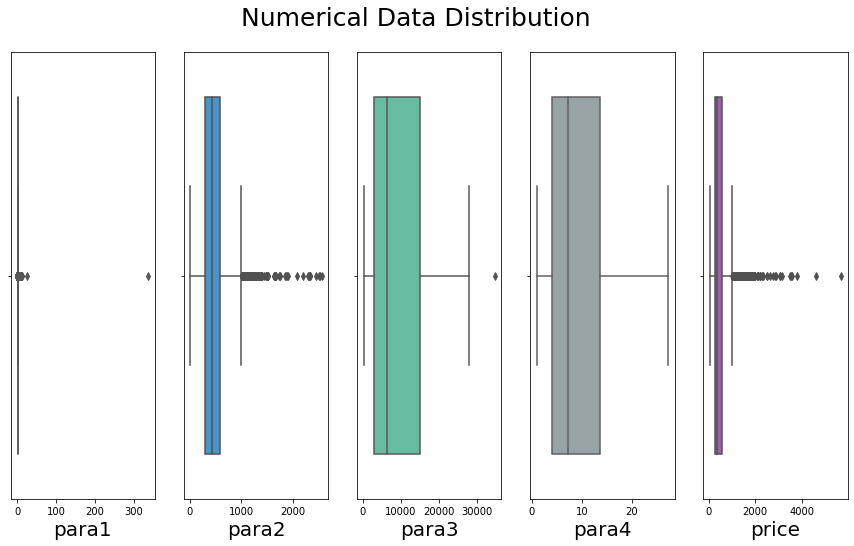

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,8))

numerical_features = [i for i in df_new.columns if df_new[i].dtype=='int64'] + [i for i in df_new.columns if df_new[i].dtype=='float64']

colors = ['#e74c3c', '#3498db', '#59C9A5', '#95a5a6', '#9b59b6']

for i in range(len(numerical_features)):
    sns.boxplot(data=df_new, x=numerical_features[i], ax=ax[i], color=colors[i])
    ax[i].set_xlabel(numerical_features[i], fontsize=20)
    ax[i].set_ylabel('')
plt.suptitle('Numerical Data Distribution', fontsize=25)
fig.subplots_adjust(top=0.9)

##### From the boxplots above, we can find that para1, para2, para3 and price have some outliers, and all of them are right skewed. Lets plot the distribution plot to check.

In [26]:
from scipy import stats

Text(0.5, 1.0, 'Feature - price Distribution')

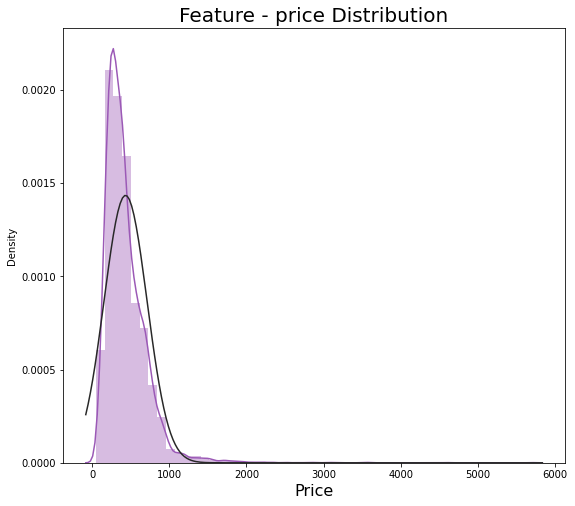

In [27]:
plt.rcParams['figure.figsize'] = [9, 8]
sns.distplot(df_new[numerical_features[-1]], color='#9b59b6',fit=stats.norm);
plt.xlabel('Price', fontsize=16);

plt.title('Feature - price Distribution', fontsize=20)

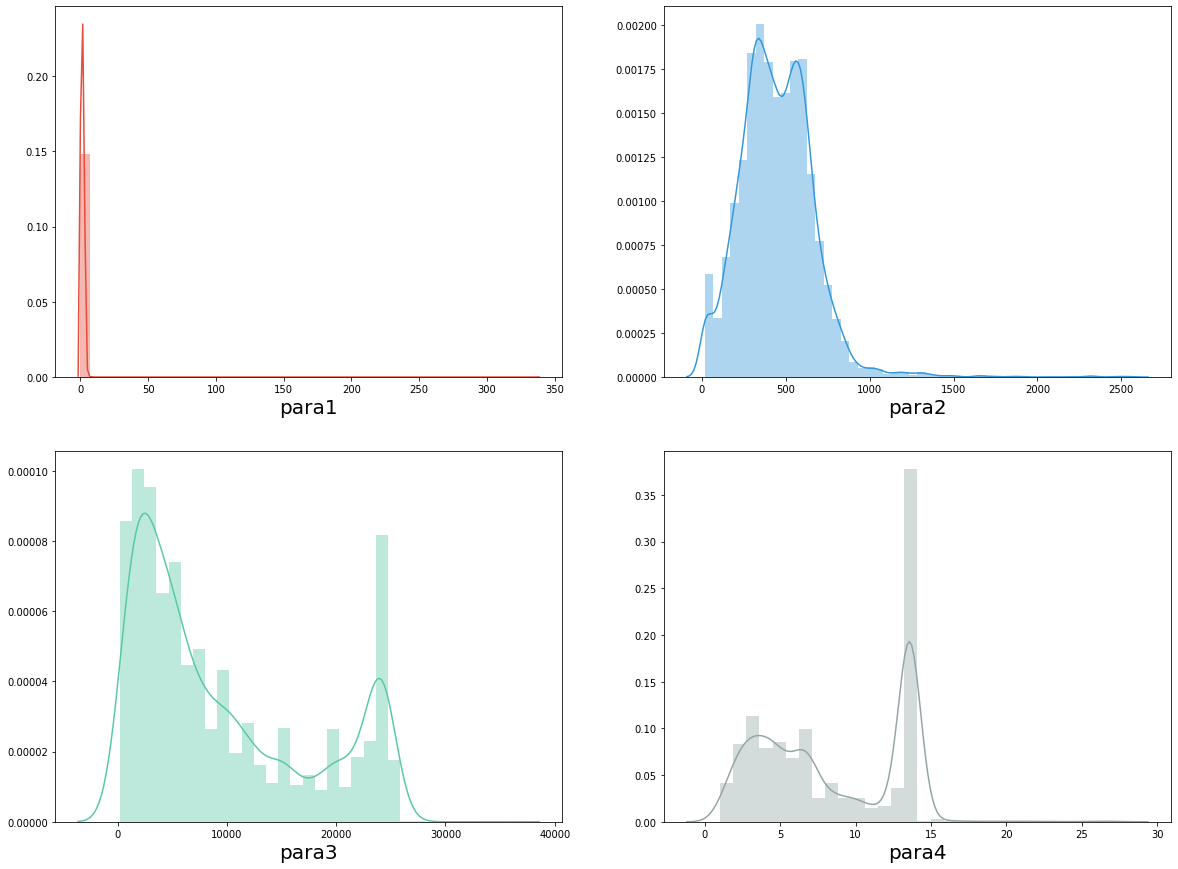

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

numerical_features = [i for i in df_new.columns if df_new[i].dtype=='int64'] + [i for i in df_new.columns if df_new[i].dtype=='float64']

colors = ['#e74c3c', '#3498db', '#59C9A5', '#95a5a6', '#9b59b6']

counter = 0
for i in range(2):
    for j in range(2):
        sns.distplot(df_new[numerical_features[counter]], ax=ax[i][j], color=colors[counter])
        ax[i][j].set_xlabel(numerical_features[counter], fontsize=20)
        ax[i][j].set_ylabel('')
        counter+=1

In [29]:
#function to return dist and proba plots for the feature
def plot_normality(df,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.distplot(df[feature],fit=stats.norm)
    plt.subplot(1,2,2)
    stats.probplot(df[feature],plot=plt)
    plt.show()

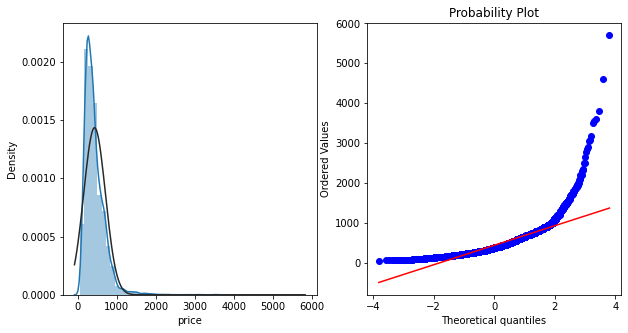

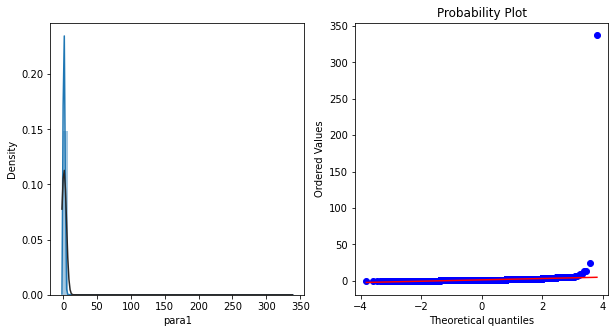

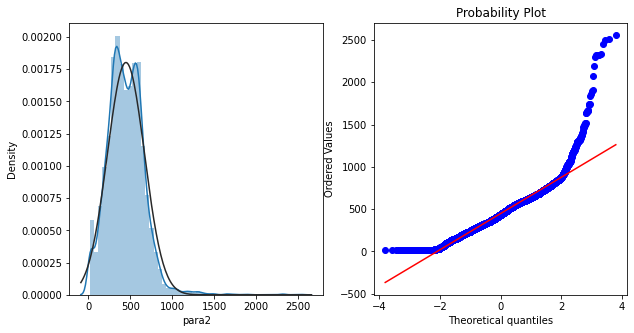

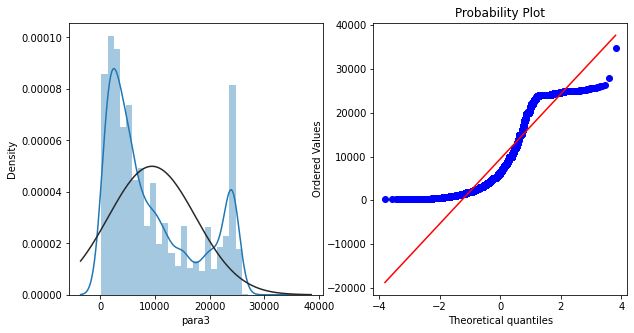

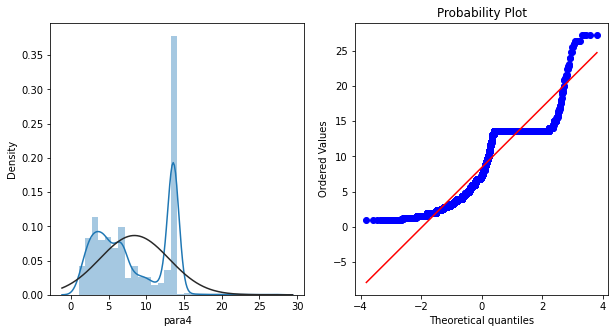

In [30]:
# plot price
plot_normality(df_new,'price')
# plot para1
plot_normality(df_new,'para1')
# plot para2
plot_normality(df_new,'para2')
# plot para3
plot_normality(df_new,'para3')
# plot para4
plot_normality(df_new,'para4')

In [31]:
# function to calculate skewness
def cal_skewness(df):
    df_numeric = df.dtypes[df.dtypes!='object'].index
    # calculate the skew and sort
    skew_features = df[df_numeric].skew().sort_values(ascending=False)
    skewness = pd.DataFrame({'Skewness': skew_features})
    return skewness

cal_skewness(df_new)

,Skewness
para1,87.824088
price,3.631727
para2,1.377928
para3,0.763763
para4,0.133714


- The distribution plots and the skewness table indicate that all of the numerical features show right skewed, `price`, `para1` and `para2` showed heavily right skewed. 
- Feature `para1` has the highest skew, then `price`. 
- `price` is not normal and shows 'peakedness', positive skewness and does not follow the diagonal line.
- In case of resolve the skewness, we can follow these steps:
    - Remove the outliers
    - log transformation

##### Curious about `para1`, let's take a look at it

In [32]:
df_new['para1'].unique()

array([  1,   0,   4,   3,   2,   5,  24,   7,   6,  13,   9,   8, 337],
      dtype=int64)

In [33]:
df_new['para1'].value_counts()

1      6985
3      1598
0       813
2       266
4       164
5        51
6         6
7         3
13        2
9         2
24        1
8         1
337       1
Name: para1, dtype: int64

In [34]:
# first we check para1's outliers
df_new[(df_new['para1']==337)|(df_new['para1']==24)|(df_new['para1']==13)].sort_values(by='para1')
# since it only has one row, we can drop this row to remove the outlier

,loc1,loc2,para1,dow,para2,para3,para4,price
4501,2,24,13,Fri,363,7920.0,13.2,490.0
8243,5,50,13,Fri,292,2528.0,6.8,350.0
1559,0,06,24,Fri,314,3360.0,13.6,450.0
7130,6,63,337,Mon,442,25000.0,13.6,1150.0


- Feature `para1` contains 13 unique values
- most frequent values are between 0-7
- Since i don't have any information explain the features meaning, so make me curious if this feature's data type is incorrect

### 3.2 Check the categorical features distribution

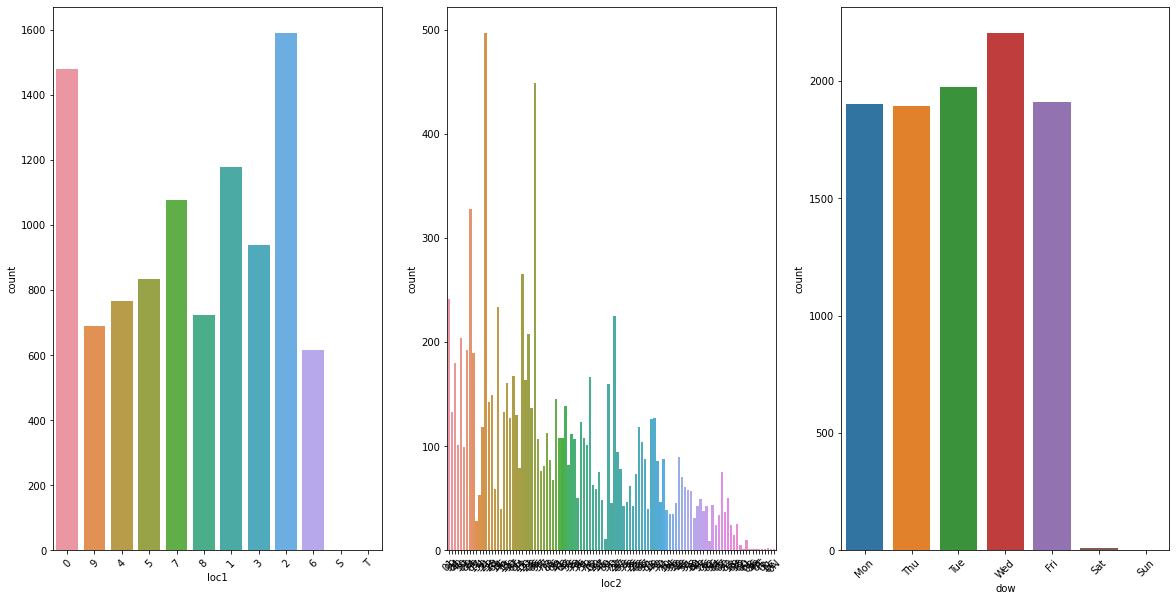

In [35]:
# Visualize categorical features' occurance
cat_features = [i for i in df_new.columns if df_new[i].dtype=='object']

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for variable, subplot in zip(cat_features, ax.flatten()):
    sns.countplot(df_new[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

###### From the categorical feature distribution plots, we can see when `loc1` is `2`, it reach it's peak, while when it's equal to `S` and `T`, it barely shows any occurance. For the feature `dow`, weekend shows low occurance, while in the weakday shows high occurance, especiall on Wednesday, it reaches the peak. For feature`loc2`, we can see that there are too many unique values, which in the following process, we can bin this feature into smaller groups, and check it's distribution.

### 3.3 Check the numeric features VS `price` relationship

Text(0.5, 0.98, 'Numerical Features VS Price')

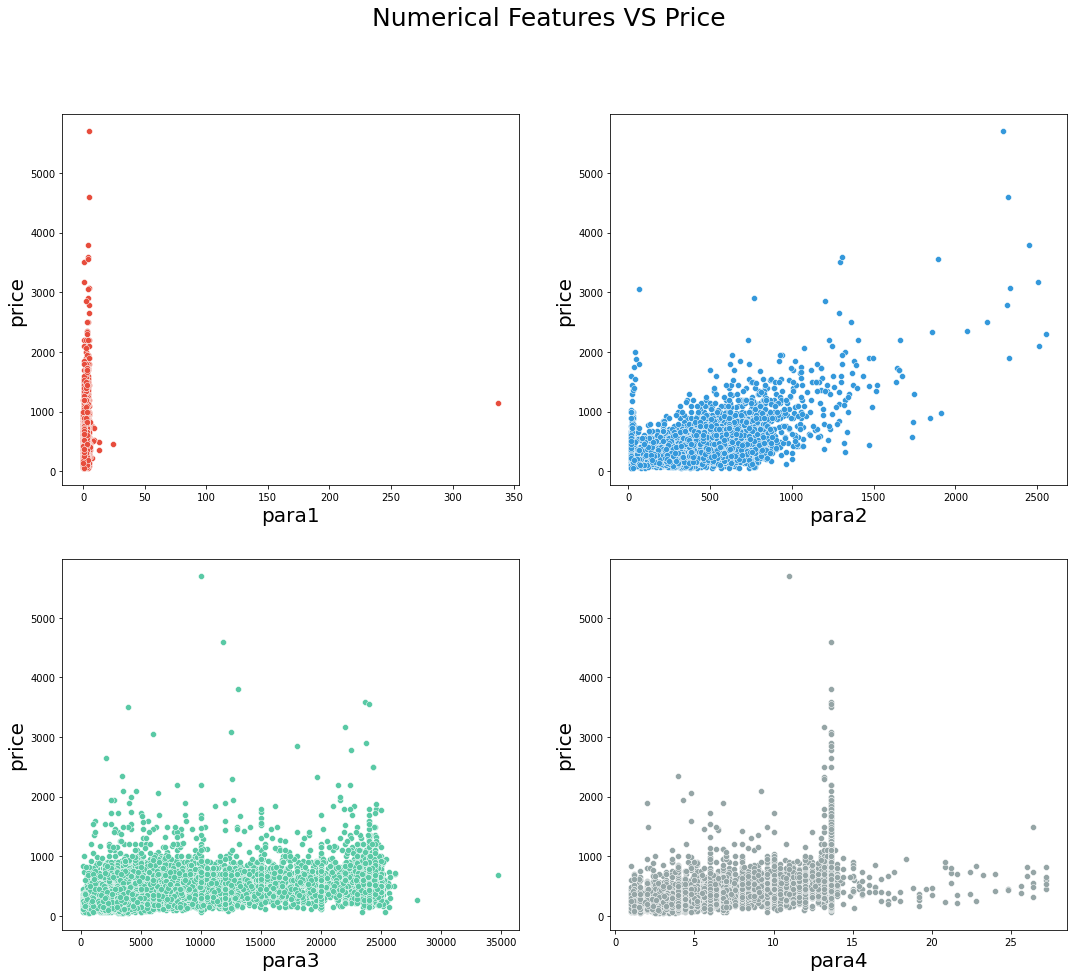

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,15))

numerical_features = [i for i in df_new.columns if df_new[i].dtype=='int64'] + [i for i in df_new.columns if df_new[i].dtype=='float64']

colors = ['#e74c3c', '#3498db', '#59C9A5', '#95a5a6', '#9b59b6']

counter = 0
for i in range(2):
    for j in range(2):
        sns.scatterplot(x = df_new[numerical_features[counter]], y= df_new['price'],ax=ax[i][j], color=colors[counter])
        ax[i][j].set_xlabel(numerical_features[counter], fontsize=20)
        ax[i][j].set_ylabel('price', fontsize=20)
        counter+=1
        
plt.suptitle('Numerical Features VS Price', fontsize=25)
# fig.subplots_adjust(top=0.9)

- Only `para2` in the scatter plots above, shows a weak positive linear relationship with `price`, which means that as para2 increases, price also increases.
- all the rest features, don't really show much linear relationship with `price`. 
- For feature `para1`, there is 3 data points which are not representative of the typical case. Therefore, we'll define them as outlier and delete it.
- Same for feature `para3`, there is one data point which is at the far right coner, it's not representative of the typical case. Therefore, we'll define them as outlier and delete it.

##### Check the correlation matrix

<AxesSubplot:>

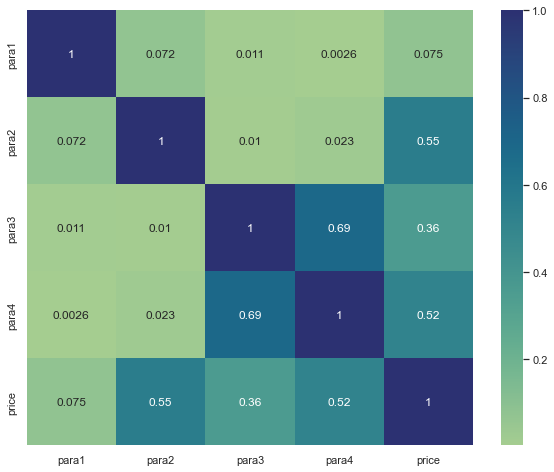

In [37]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(df_new.corr().abs(),annot=True,cmap="crest")

- `para1` pretty much not correlated to `price` 
- `para2` and `para4` is moderate highly correlated to `price`
- `para3` and `para4` shows a situation of multicollinearity. If we have more information about these two features, we may just pick one of them to use in our model
##### Based on all the explorations above, let's convert `para1` to categorical feature, and visualize it

<AxesSubplot:xlabel='para1', ylabel='count'>

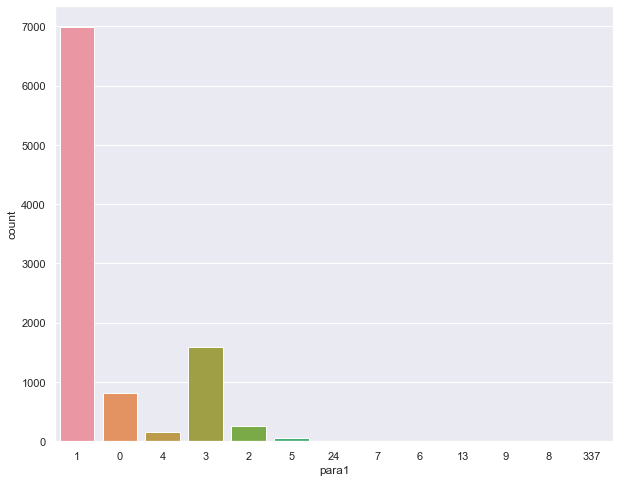

In [38]:
tst = df_new.copy()
tst['para1'] = tst['para1'].astype(str)
sns.countplot(data=tst, x=tst['para1'])
# plt.rcParams['figure.figsize'] = [10, 8]

After converting `para1` from int to str, now it makes more sense why it has no lieaner relationship with feature `price`

In [39]:
df_new['para1'] = df_new['para1'].astype(str)
cat_features = [i for i in df_new.columns if df_new[i].dtype=='object']

### 3.4 Check the categorical features VS `price` relationship

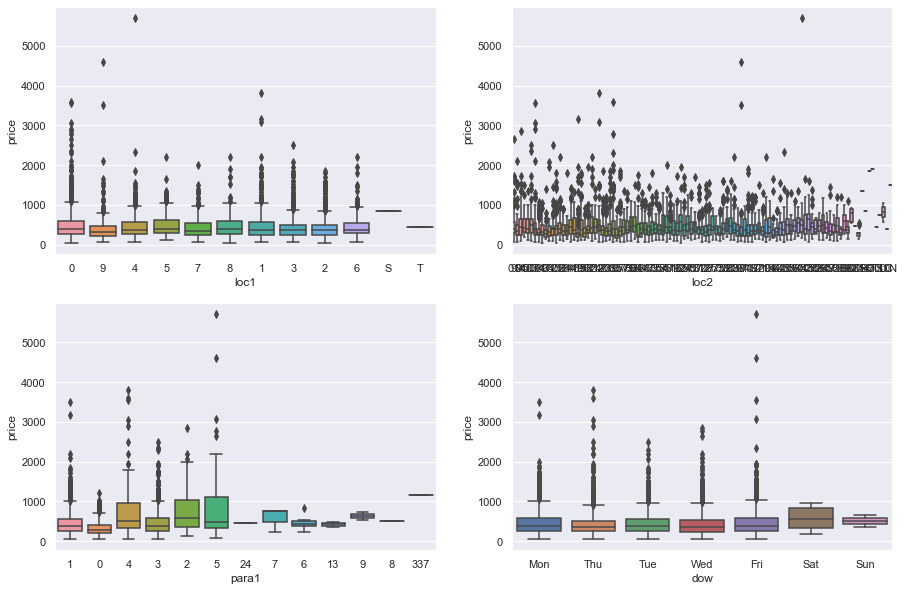

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
for var, subplot in zip(cat_features, ax.flatten()):
    sns.boxplot(x=var, y='price', data=df_new, ax=subplot)

- When categorical feature `loc1`='0', it shows a highest average price, besides class is 'S' or 'T', all the other classes' variance didn't show a big difference. Class 4 has the peak price.

- Feature `dow`, during the weekdays the price average are stable and didn't have a big variance, while Saturday shows the highest average among all the other days. Friday has the peak price.

- For feature`loc2`, we can find there are too many unique values, which in the following process, we can bin this feature into smaller groups and look at it's relationship with `price`
- Feature `para1` class 5 shows the highest price compare to other classes.

##### Let's take each categorical features out and look at more details about their relationship with `price`

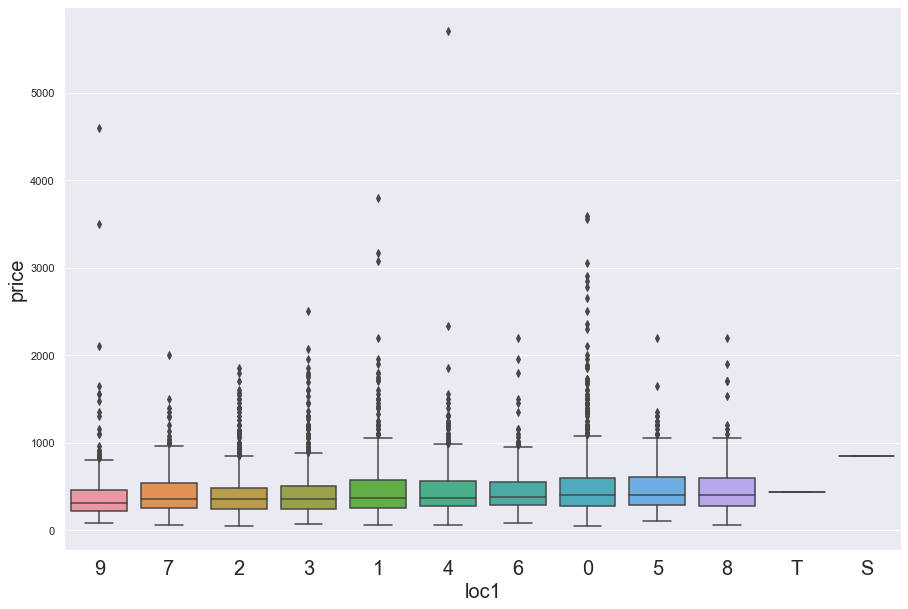

In [41]:
fig, ax = plt.subplots(figsize = (15,10))

sorted_loc1 = df_new.groupby(['loc1'])['price'].median().sort_values()
ax = sns.boxplot(x=df_new['loc1'], y=df_new['price'], order=list(sorted_loc1.index))

ax.set_xlabel('loc1',fontsize = 20)
ax.set_ylabel('price',fontsize = 20)

labels = list(sorted_loc1.index)
ax.set_xticklabels(labels, fontsize = 20);

- Sorted `loc1` by median price. 
- This plot shows that in the cheapest price is close to 0, and the most expensive price is over 5,000. For most of the classes in `loc1`, the dispersion between the prices is very low (price are close to each other). 

##### `loc2` is too hard to plot beacauses it contains over 90 classes, but we will plot it later

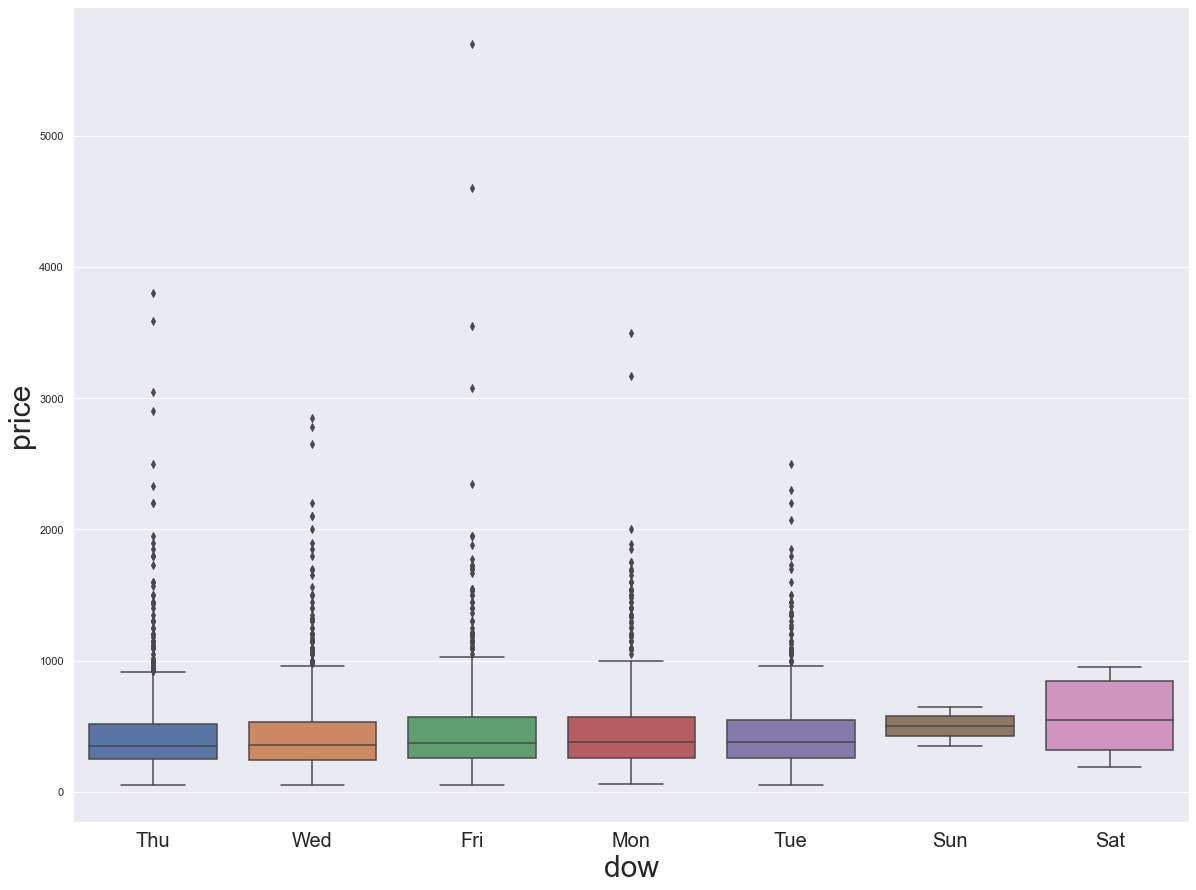

In [42]:
fig, ax = plt.subplots(figsize = (20,15))

sorted_dow = df_new.groupby(['dow'])['price'].median().sort_values()
ax = sns.boxplot(x=df_new['dow'], y=df_new['price'], order=list(sorted_dow.index))

ax.set_xlabel('dow',fontsize = 30)
ax.set_ylabel('price',fontsize = 30)

labels = list(sorted_dow.index)

ax.set_xticklabels(labels, fontsize = 20);


- Sorted `dow` by median price.
- This plot shows that in the cheapest price is close to 0 in the weekdays, and the most expensive price is on Friday which is over 5,000. 
- For most of the classes in `dow`, the dispersion between the prices is very low (price are close to each other).

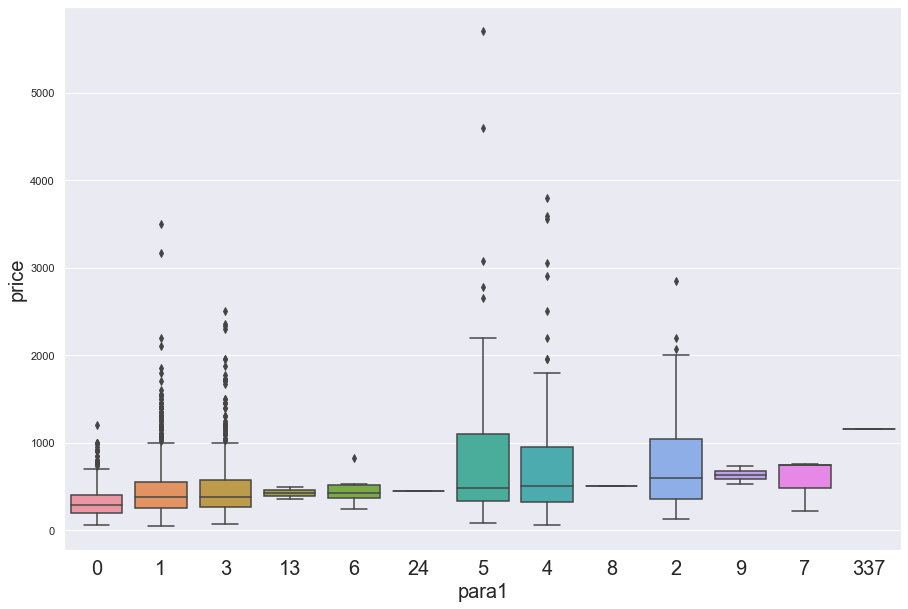

In [43]:
fig, ax = plt.subplots(figsize = (15,10))

sorted_para1 = df_new.groupby(['para1'])['price'].median().sort_values()
ax = sns.boxplot(x=df_new['para1'], y=df_new['price'], order=list(sorted_para1.index))

ax.set_xlabel('para1',fontsize = 20)
ax.set_ylabel('price',fontsize = 20)

labels = list(sorted_para1.index)
ax.set_xticklabels(labels, fontsize = 20);

- Sorted `para1` by median price.
- This plot shows that in the cheapest price is close to 0, and the most expensive price fall into class 5 which is over 5,000 
- For most of the classes in `para1`, the dispersion between the prices is very low (price are close to each other), except class 5, 4, 2.

### 3.5 Correlation matrix on numeric features

<AxesSubplot:>

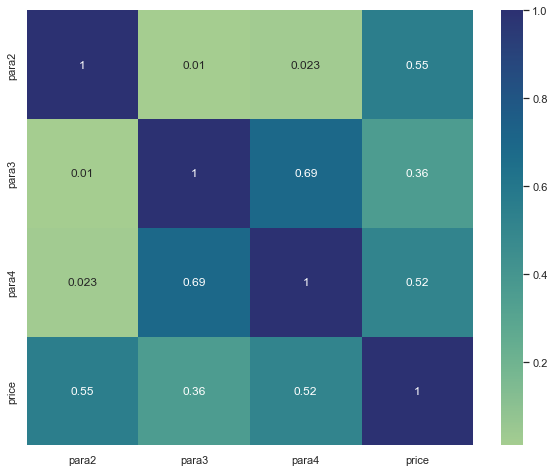

In [44]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(df_new.corr().abs(),annot=True,cmap="crest")

- `para2` and `para4` is moderate highly correlated to `price`
- `para3` and `para4` shows a situation of multicollinearity. If we have more information about these two features, we may just pick one of them to use in our model

In [45]:
df_new[['para3','para4']].describe()

,para3,para4
count,9893.000000,9893.000000
mean,9452.867704,8.413242
std,7988.784764,4.607946
min,200.000000,1.000000
25%,2857.000000,4.000000
50%,6340.000000,7.200000
75%,15000.000000,13.600000
max,34782.000000,27.200000


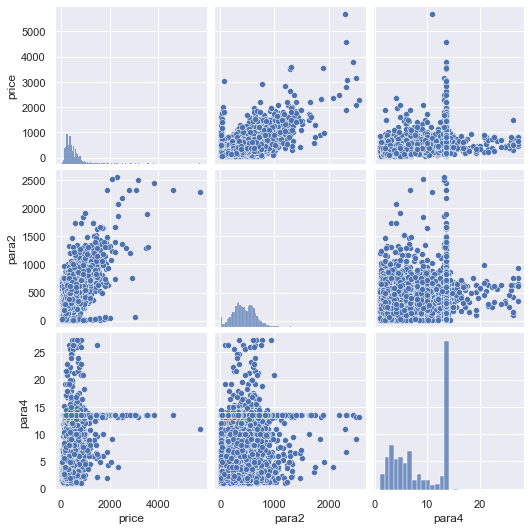

In [46]:
#scatterplot
sns.set()
cols = ['price', 'para2', 'para4']
sns.pairplot(df_new[cols], size = 2.5)
plt.show();

### 4. Preprocessing
#### Steps
- Remove certain feature's outlier/s
- Feature/s transformation
- Drop rows contain odd values (categorical)
- Bins categorical feature to small groups (for those categorical feature contains >20 unique values)
- Encoding categorical features
- Data scaling

### 4.1.1 Remove certain feature's outlier/s
- There are probably others outliers in the data, but we can't remove all of them, because it may affect on our models. Thus, instead of removing them all, we will just manage to remove some of them to make our models robust.
- `para1` drop classes: 337, 24, 13
- `para3` drop value = 34782

In [47]:
df1 = df_new.copy()
df1 = df1.query("para1!='337' and para1!='24' and para1!='13' and para3!=34782")
df1.shape

(9888, 8)

##### After remove `para3` outliers, the skewness improved, but `price`  shows highest skewed, we will apply log transformation to `price` next.

In [48]:
cal_skewness(df1)

,Skewness
price,3.634219
para2,1.377384
para3,0.762470
para4,0.134474


### 4.1.2 Apply Feature transformation (log transformation) and visualize it

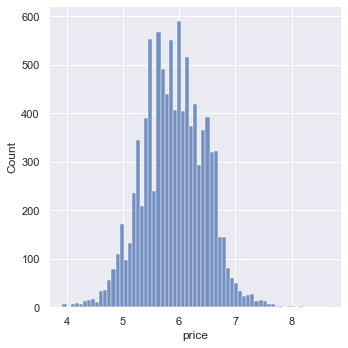

In [49]:
lg_price = np.log(df1['price'])
sns.displot(lg_price)

##### `price` distribution definitely imroved a lot, and shows a normal distribution, and follow the diagonal line. Let's create a new feature: log_price

In [50]:
df2 = df1.copy()

# apply log and boxcox transformation and create new features
df2['log_price'] = np.log(df2['price'])
df2['boxcox_para2'] = boxcox(df2['para2'])[0]
df2['boxcox_para3'] = boxcox(df2['para3'])[0]

# fit_price, lam = scs.boxcox(df['Price_in_thousands'])

df2.head()

,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3
0,0,01,1,Mon,662,3000.0,3.8,73.49,4.297149,94.940357,22.745951
1,9,99,1,Thu,340,2760.0,9.2,300.00,5.703782,61.717594,22.236371
2,0,04,0,Mon,16,2700.0,3.0,130.00,4.867534,7.559847,22.103649
3,4,40,1,Mon,17,12320.0,6.4,365.00,5.899897,7.917493,33.022585
4,5,50,1,Thu,610,2117.0,10.8,357.50,5.879135,90.067968,20.678181


In [51]:
df2.skew()

para1           1.502801
para2           1.377384
para3           0.762470
para4           0.134474
price           3.634219
log_price       0.032056
boxcox_para2    0.132637
boxcox_para3   -0.078935
dtype: float64

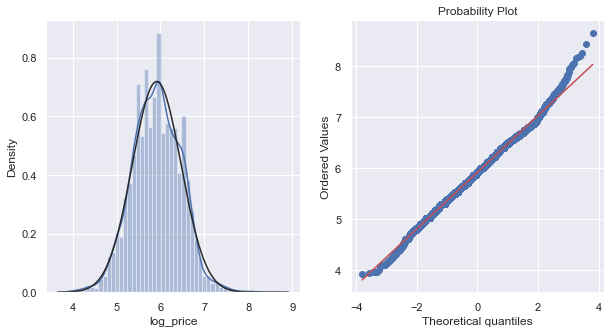

In [52]:
plot_normality(df2,'log_price')

In [53]:
df2.dtypes

loc1             object
loc2             object
para1            object
dow              object
para2             int64
para3           float64
para4           float64
price           float64
log_price       float64
boxcox_para2    float64
boxcox_para3    float64
dtype: object

### 4.2 Visualize the numerical features relationship with transformed feature - `log_price` 

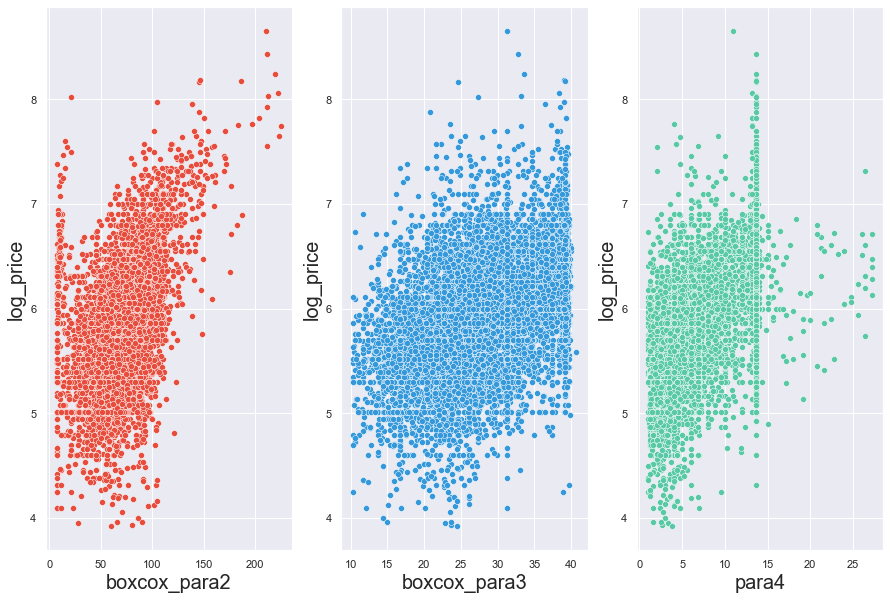

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
numerical_features = ['boxcox_para2','boxcox_para3','para4']

colors = ['#e74c3c', '#3498db', '#59C9A5']

counter = 0
for i in range(3):
    sns.scatterplot(x = df2[numerical_features[counter]], y= df2['log_price'],ax=ax[i], color=colors[counter])
    ax[i].set_xlabel(numerical_features[counter], fontsize=20)
    ax[i].set_ylabel('log_price', fontsize=20)
    counter+=1

- After applying log transformation to `price`, we can see that `boxcox_para2`,`boxcox_para3`, and `para4` both to be positive linearly related with `log_price`. Means as one feature increases, the price also increases.
- `para2` shows a higher slope of the linear relationship with `log_price`.

### 4.3 Feature engineering

In [55]:
df2.loc1.sort_values().unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'S', 'T'],
      dtype=object)

In [56]:
df2.loc2.sort_values().unique()

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0B',
       '0C', '0L', '0N', '0T', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82',
       '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93',
       '94', '95', '96', '97', '98', '99', 'S6', 'TS'], dtype=object)

In [57]:
# store odd feature classes
f1 = df2['loc1'].isin(['S','T'])
f2 = df2['loc2'].isin(['0B', '0C', '0L', '0N', '0T', 'S6', 'TS'])
  
print(df2[f1].shape)
df2[f1]

(2, 11)


,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3
3016,S,S6,3,Fri,1289,24000.0,13.6,850.0,6.745236,145.604220,39.146349
5469,T,TS,3,Fri,1472,1600.0,2.0,440.0,6.086775,158.511353,19.132042


In [58]:
print(df2[f2].shape)
df2[f2]

(7, 11)


,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3
2877,0,0B,2,Mon,801,1091.0,9.0,1350.0,7.207860,107.320777,17.170758
3016,S,S6,3,Fri,1289,24000.0,13.6,850.0,6.745236,145.604220,39.146349
4820,0,0T,2,Mon,1473,4000.0,2.0,1890.0,7.544332,158.580209,24.580114
5469,T,TS,3,Fri,1472,1600.0,2.0,440.0,6.086775,158.511353,19.132042
5603,0,0L,2,Wed,1127,10000.0,13.6,750.0,6.620073,133.604782,31.289507
7675,0,0C,3,Fri,623,1500.0,6.0,400.0,5.991465,91.299898,18.789398
8381,0,0N,3,Fri,1298,3500.0,2.1,1500.0,7.313220,146.254098,23.713840


##### Since there total 7 rows  from loc1 and loc2 that contains odd classes, we can drop them for now, but if we can obtain more info on these 2 features, we could replace/modify the value

In [59]:
indexes = df2[f1].index.tolist() + df2[f2].index.tolist()
df3 = df2.copy()

df3.drop(index=indexes,inplace=True)

In [60]:
print(df2.shape, df3.shape)
df3.head()

(9888, 11) (9881, 11)


,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3
0,0,01,1,Mon,662,3000.0,3.8,73.49,4.297149,94.940357,22.745951
1,9,99,1,Thu,340,2760.0,9.2,300.00,5.703782,61.717594,22.236371
2,0,04,0,Mon,16,2700.0,3.0,130.00,4.867534,7.559847,22.103649
3,4,40,1,Mon,17,12320.0,6.4,365.00,5.899897,7.917493,33.022585
4,5,50,1,Thu,610,2117.0,10.8,357.50,5.879135,90.067968,20.678181


### 4.3.1 Create new feature `loc2_Group`
- Since `loc2` contains 99 unique values, we can bin these value into smaller groups (5 groups)
- Binning `loc2` based on avg prices of each class

In [61]:
df4 = df3.copy()
df5 = df4.groupby(['loc2'])['price'].mean()

df5 = df4.merge(df5.reset_index(), how='left', on='loc2')

df5.head()

,loc1,loc2,para1,dow,para2,para3,para4,price_x,log_price,boxcox_para2,boxcox_para3,price_y
0,0,01,1,Mon,662,3000.0,3.8,73.49,4.297149,94.940357,22.745951,466.635167
1,9,99,1,Thu,340,2760.0,9.2,300.00,5.703782,61.717594,22.236371,408.149323
2,0,04,0,Mon,16,2700.0,3.0,130.00,4.867534,7.559847,22.103649,511.948667
3,4,40,1,Mon,17,12320.0,6.4,365.00,5.899897,7.917493,33.022585,489.021485
4,5,50,1,Thu,610,2117.0,10.8,357.50,5.879135,90.067968,20.678181,445.046158


In [62]:
df5.price_y.describe()

count    9881.000000
mean      432.661731
std        58.416058
min       299.833000
25%       391.581356
50%       427.674565
75%       472.788944
max      1850.000000
Name: price_y, dtype: float64

In [63]:
bins = [0,300,430,1900]
labels=['Low','Medium','High']

df5['loc2_Group'] = pd.cut(df5['price_y'],bins=bins,labels=labels)
df5 = df5.rename(columns={'price_x': 'price', 'price_y': 'loc2_avg_price'})
df5.head()

,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3,loc2_avg_price,loc2_Group
0,0,01,1,Mon,662,3000.0,3.8,73.49,4.297149,94.940357,22.745951,466.635167,High
1,9,99,1,Thu,340,2760.0,9.2,300.00,5.703782,61.717594,22.236371,408.149323,Medium
2,0,04,0,Mon,16,2700.0,3.0,130.00,4.867534,7.559847,22.103649,511.948667,High
3,4,40,1,Mon,17,12320.0,6.4,365.00,5.899897,7.917493,33.022585,489.021485,High
4,5,50,1,Thu,610,2117.0,10.8,357.50,5.879135,90.067968,20.678181,445.046158,High


##### Plot the new feature `loc2_Group` vs `price`

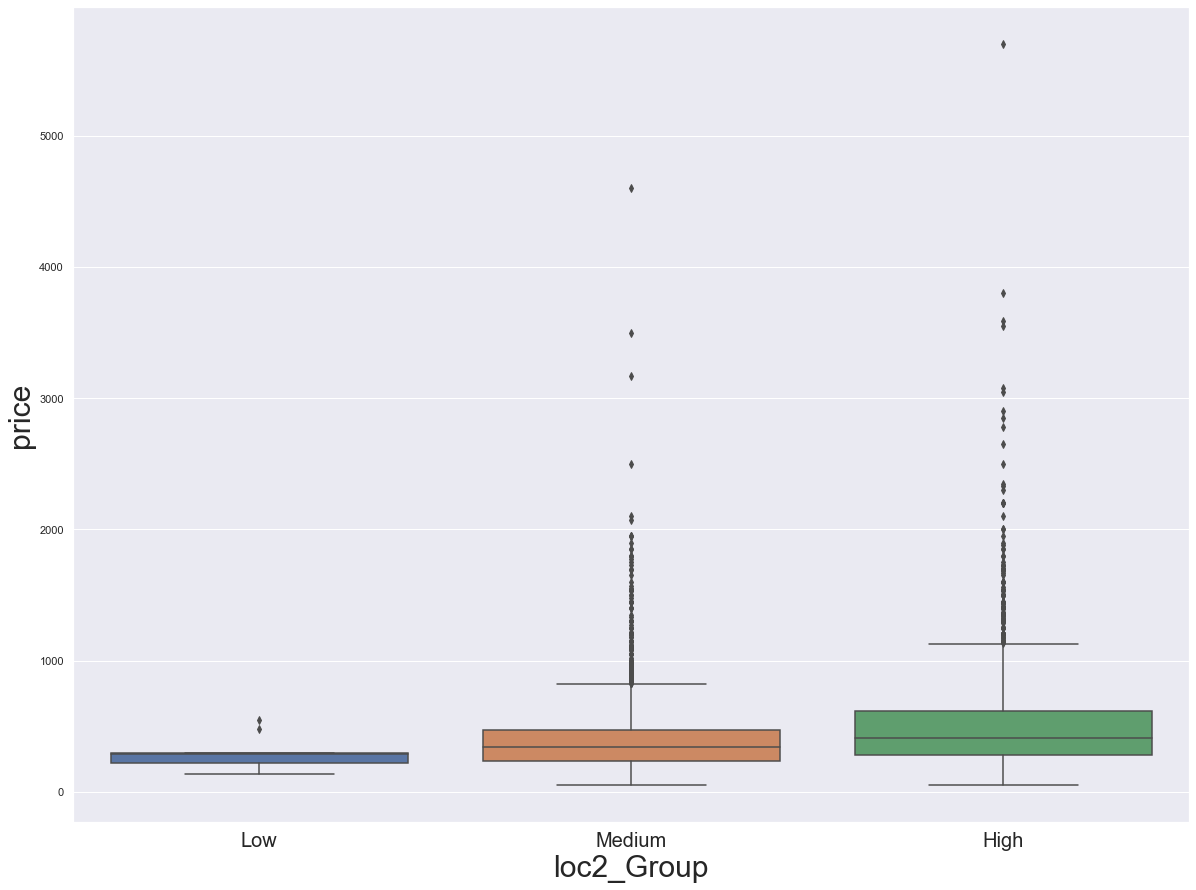

In [64]:
fig, ax = plt.subplots(figsize = (20,15))

sorted_loc2_Group = df5.groupby(['loc2_Group'])['price'].median().sort_values()
ax = sns.boxplot(x=df5['loc2_Group'], y=df5['price'], order=list(sorted_loc2_Group.index))

ax.set_xlabel('loc2_Group',fontsize = 30)
ax.set_ylabel('price',fontsize = 30)

labels = list(sorted_loc2_Group.index)

ax.set_xticklabels(labels, fontsize = 20);


### 4.3.2 Encoding categorical features
- First, I am curious if `dow` is a cyclic feature or not
- Convert `dow` from weekday name to day of week
- Encode the cyclic feature by computing the sin and cosine of the feature
    - Visualize the new 2-dimensional transformed feature vector with a scatterplot to check cyclic nature or not
- Encoding all the rest features

In [65]:
df6 = df5.copy()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
days = dict(zip(dow_names, range(7)))
df6['dow_dayofweek'] = df6['dow'].map(days)

In [66]:
# create a function to transform cyclic feature
def transform_cyclic(df, feature):
    max_value = feature.max()
    df['dow_sin_values'] = [math.sin((2*pi*x)/max_value) for x in list(feature)]
    df['dow_cos_values'] = [math.cos((2*pi*x)/max_value) for x in list(feature)]
    return df

In [67]:
df6 = transform_cyclic(df6, df6['dow_dayofweek'])
df6.head()

,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3,loc2_avg_price,loc2_Group,dow_dayofweek,dow_sin_values,dow_cos_values
0,0,01,1,Mon,662,3000.0,3.8,73.49,4.297149,94.940357,22.745951,466.635167,High,0,0.000000e+00,1.0
1,9,99,1,Thu,340,2760.0,9.2,300.00,5.703782,61.717594,22.236371,408.149323,Medium,3,1.224647e-16,-1.0
2,0,04,0,Mon,16,2700.0,3.0,130.00,4.867534,7.559847,22.103649,511.948667,High,0,0.000000e+00,1.0
3,4,40,1,Mon,17,12320.0,6.4,365.00,5.899897,7.917493,33.022585,489.021485,High,0,0.000000e+00,1.0
4,5,50,1,Thu,610,2117.0,10.8,357.50,5.879135,90.067968,20.678181,445.046158,High,3,1.224647e-16,-1.0


##### Visualize sin and cos dow features to check if shows cyclic nature

<AxesSubplot:xlabel='dow_sin_values', ylabel='dow_cos_values'>

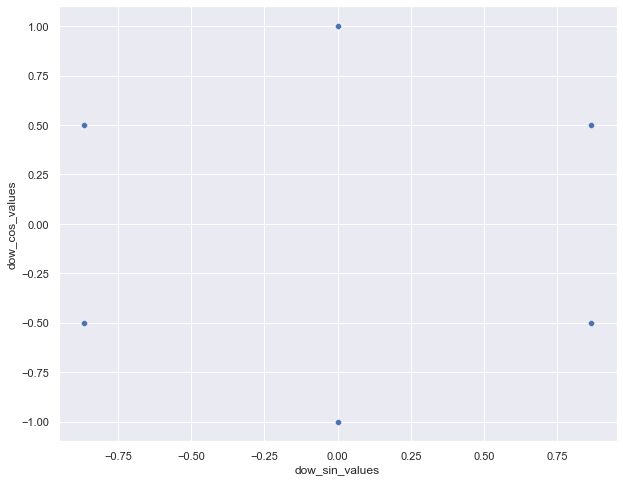

In [68]:
sns.scatterplot(x = df6['dow_sin_values'], y= df6['dow_cos_values'])

##### The scatterplot above clearly indicates the cyclic nature of the `dow_dayofweek` feature. Thus, we can encoded `dow_dayofweek` values (from 0 to 6) now into a 2-dimensional vector.

In [69]:
df6.head(3)

,loc1,loc2,para1,dow,para2,para3,para4,price,log_price,boxcox_para2,boxcox_para3,loc2_avg_price,loc2_Group,dow_dayofweek,dow_sin_values,dow_cos_values
0,0,01,1,Mon,662,3000.0,3.8,73.49,4.297149,94.940357,22.745951,466.635167,High,0,0.000000e+00,1.0
1,9,99,1,Thu,340,2760.0,9.2,300.00,5.703782,61.717594,22.236371,408.149323,Medium,3,1.224647e-16,-1.0
2,0,04,0,Mon,16,2700.0,3.0,130.00,4.867534,7.559847,22.103649,511.948667,High,0,0.000000e+00,1.0


In [70]:
df7 = df6.copy()
df7 = df7.drop(columns=['loc2','dow','loc2_avg_price','dow_dayofweek','para2','para3'], axis=1)
df7['loc2_Group'] = df7['loc2_Group'].astype(str)
df7.head()

,loc1,para1,para4,price,log_price,boxcox_para2,boxcox_para3,loc2_Group,dow_sin_values,dow_cos_values
0,0,1,3.8,73.49,4.297149,94.940357,22.745951,High,0.000000e+00,1.0
1,9,1,9.2,300.00,5.703782,61.717594,22.236371,Medium,1.224647e-16,-1.0
2,0,0,3.0,130.00,4.867534,7.559847,22.103649,High,0.000000e+00,1.0
3,4,1,6.4,365.00,5.899897,7.917493,33.022585,High,0.000000e+00,1.0
4,5,1,10.8,357.50,5.879135,90.067968,20.678181,High,1.224647e-16,-1.0


##### Creating dummy variables

In [71]:
features_to_encode = [i for i in df7.columns if df7[i].dtype=='object']

df_dummy = df7.copy()
df_dummy = pd.get_dummies(df_dummy, columns = features_to_encode)
df_dummy = df_dummy.reset_index().drop(['index'],axis=1)
print(df_dummy.shape)
df_dummy.head(3)

(9881, 30)


,para4,price,log_price,boxcox_para2,boxcox_para3,dow_sin_values,dow_cos_values,loc1_0,loc1_1,loc1_2,...,para1_3,para1_4,para1_5,para1_6,para1_7,para1_8,para1_9,loc2_Group_High,loc2_Group_Low,loc2_Group_Medium
0,3.8,73.49,4.297149,94.940357,22.745951,0.000000e+00,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,9.2,300.00,5.703782,61.717594,22.236371,1.224647e-16,-1.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3.0,130.00,4.867534,7.559847,22.103649,0.000000e+00,1.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


##### Now we have 30 features after encoding categorical features

### 4.4 Train Test Split

In [72]:
X = df_dummy.drop(columns=['price','log_price'],axis=1)
y = df_dummy[['log_price']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=42)

print(X_train.shape, X_test.shape)

(6916, 28) (2965, 28)


### 4.5 Applying PCA analysis
- PCA analysis shows how much of the variance is explained by each of the principal components. 

In [73]:
# Lets decompose each row into 10 principal components
def get_pca(df, pca_comp):
    pca = PCA(pca_comp)
    X_dec = pca.fit_transform(df)
    return X_dec, pca

In [74]:
#Decomposing the train set:
pca_train_rlt, pca_train = get_pca(X_train, 10)

#Decomposing the test set:
pca_test_rlt, pca_test = get_pca(X_test, 10)

#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 11)]
scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
print(scree)

          Component  Explained Variance Ratio
0   PCA Component 1                  0.878882
1   PCA Component 2                  0.103169
2   PCA Component 3                  0.013732
3   PCA Component 4                  0.001057
4   PCA Component 5                  0.000831
5   PCA Component 6                  0.000648
6   PCA Component 7                  0.000235
7   PCA Component 8                  0.000208
8   PCA Component 9                  0.000188
9  PCA Component 10                  0.000163


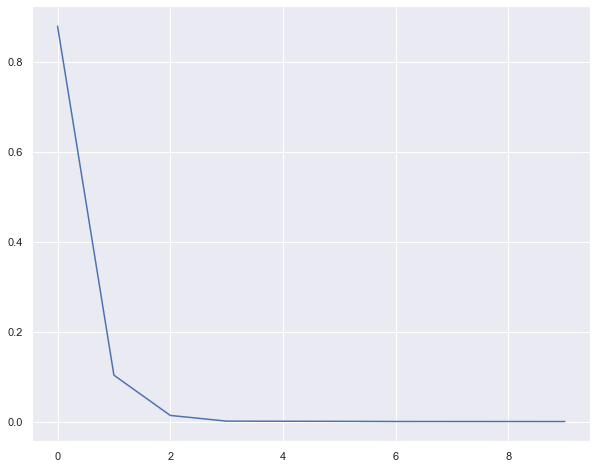

In [75]:
plt.plot(pca_train.explained_variance_ratio_)

##### Result shows, the first component is by far the most important and explains most of the variance (87%).
- Let's check the first component

In [76]:
#Sorting the values of the first principal component by how large each one is
df_pca = pd.DataFrame({'PCA':pca_train.components_[0], 'Features Names':list(X_train.columns)})
df_pca = df_pca.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df_pca1 = pd.DataFrame(df_pca)
df_pca1['PCA']=df_pca1['PCA'].apply(np.absolute)
df_pca1 = df_pca1.sort_values('PCA', ascending=False)

# Check top 10 features by pca value
print(df_pca1.shape)
df_pca1.head(10)

(28, 2)


,PCA,Features Names
1,0.999950,boxcox_para2
2,0.007853,boxcox_para3
15,0.003619,para1_0
0,0.003043,para4
25,0.002032,loc2_Group_High
27,0.002009,loc2_Group_Medium
18,0.001122,para1_3
17,0.001099,para1_2
6,0.001086,loc1_1
8,0.001078,loc1_3


- principal component 1 is responsible for most of the explained variance and feature `boxcox_para2` composed strongly compare to others.
- Check the 2nd component which is explain variance of 10% vs the 87% of the first principal component:

In [77]:
#Sorting the values of the first principal component by how large each one is
df_pca2 = pd.DataFrame({'PCA':pca_train.components_[1], 'Features Names':list(X_train.columns)})
df_pca2 = df_pca2.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df_pca3 = pd.DataFrame(df_pca2)
df_pca3['PCA']=df_pca3['PCA'].apply(np.absolute)
df_pca3 = df_pca3.sort_values('PCA', ascending=False)

# Check top 10 features by pca value
print(df_pca3.shape)
df_pca3.head(10)

(28, 2)


,PCA,Features Names
2,0.891330,boxcox_para3
0,0.453159,para4
1,0.008383,boxcox_para2
6,0.004526,loc1_1
25,0.004293,loc2_Group_High
4,0.004281,dow_cos_values
27,0.004225,loc2_Group_Medium
12,0.003910,loc1_7
8,0.001856,loc1_3
9,0.001639,loc1_4


- feature `boxcox_para3` in principal component 2 composed strongly compare to others.

### 4.5.1 Visualize price VS 2 Principle Components
- First, split the price into 5 categories
- Visualize each category according to their first two principal components, how good does PCA separate the different pricie categories

In [78]:
df_dummy.log_price.describe()

count    9881.000000
mean        5.913656
std         0.554783
min         3.926517
25%         5.521461
50%         5.913503
75%         6.309918
max         8.648221
Name: log_price, dtype: float64

Text(0, 0.5, 'PCA Component 2')

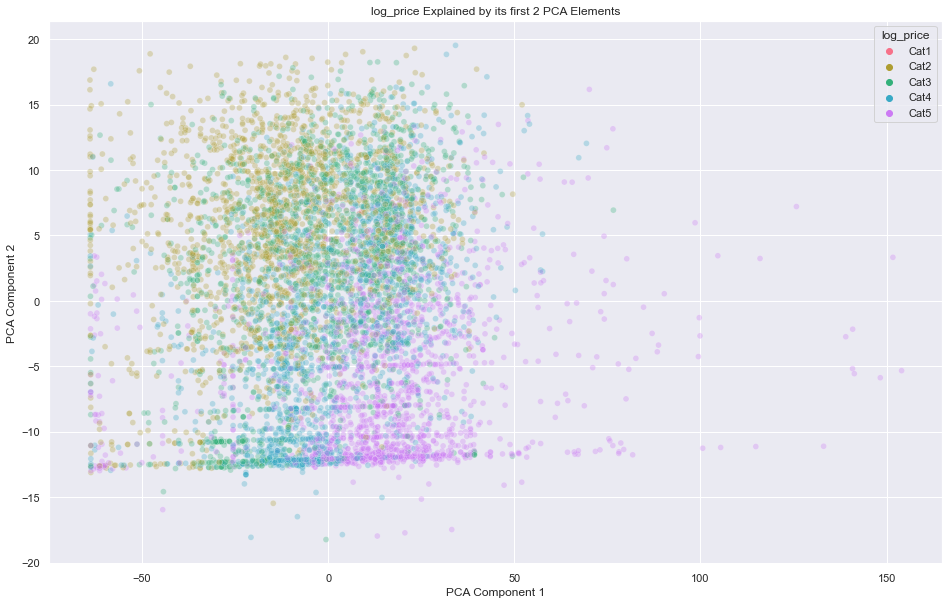

In [79]:
bins = [0, 3.93, 5.53, 5.92, 6.3, 9]
labels=['Cat1','Cat2','Cat3','Cat4', 'Cat5']

y_cat = pd.cut(y_train['log_price'],bins=bins,labels=labels)

first_comp = pca_train_rlt[:,0] 

second_comp = pca_train_rlt[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=first_comp, y=second_comp,
    hue=y_cat,
    palette=sns.color_palette("husl", 5),
    legend="full",
    alpha=0.3
)

plt.title("log_price Explained by its first 2 PCA Elements")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

- The color of each dot corresponds to its price category. 
- When we increase the value of PCA Component 1 and 2: the price go from category 2 (lower price), to a few higher price purple dots - category 5 when increase.

- The PCA plot above shows us a datum based on its most descriptive factors. 
- First browse, the plot is too dense for us to seperate each categories, but we can still see that the dark green dots are in the lower part, and progress to blue, purple as expected.
- Second, since the first component explain the 99% of the spread, the second component is more in line with a gradation of colors.


### 5. Building Models

In [80]:
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

n_folds = 5
#Validation function
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

The model may be sensitive to outliers. Thus, need to make it more robust. Robustscaler() could be used on pipeline

In [81]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))
lasso.fit(X_train,y_train)
y_pred = lasso.predict(X_test)

##### Let's see how these base default models perform on the data by evaluating the cross-validation rmsle error

In [82]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3456 (0.0045)



In [83]:
# default gbr model
gb = GradientBoostingRegressor(random_state =42)
score = rmsle_cv(gb)
print("\nGB score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GB score: 0.3192 (0.0044)



In [128]:
# Hyperparameter tuning
parameters = {'learning_rate': [0.001,0.01,0.05],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [50, 200,600],
              'max_depth'    : [4,6,8,10]
             }

grid_gb = GridSearchCV(estimator=gb, param_grid = parameters, cv = 5, n_jobs=-1)
grid_gb.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_gb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_gb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_gb.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=6, n_estimators=600,
                          random_state=42, subsample=0.5)

 The best score across ALL searched params:
 0.679874251504087

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 600, 'subsample': 0.5}


In [84]:
gb1 = GradientBoostingRegressor(n_estimators=600, learning_rate=0.01,
                                max_depth = 8, subsample = 0.2, random_state =42, 
                                min_samples_leaf=3, min_samples_split=5)

score = rmsle_cv(gb1)
print("\nGB1 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GB1 score: 0.3120 (0.0037)



In [85]:
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
ENet = make_pipeline(RobustScaler(), ElasticNet(random_state=42))
score = rmsle_cv(ENet)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ElasticNet score: 0.5528 (0.0058)



In [86]:
xgb = XGBRegressor(random_state = 42)
score = rmsle_cv(xgb)
print("\nXGBRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


XGBRegressor score: 0.3211 (0.0040)



In [157]:
params = {
        'min_child_weight': [1, 5],
        'gamma': [0.05, 0.5, 1, 2],
        'subsample': [0.5, 0.8, 1.0],
        'colsample_bytree': [0.3, 0.6],
        'max_depth': [3, 4, 5,8],
        'n_estimators':[200,600,800]
        }

grid_xgb = GridSearchCV(estimator=xgb, param_grid = params, cv = 5, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_xgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_xgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_xgb.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=600, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

 The best score across ALL searched params:
 0.6781167379629344

 The best parameters across ALL searched params:
 {'colsample_bytree': 0.3, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 600, 'subsample': 

In [87]:
xgb1 = XGBRegressor(colsample_bytree=0.3, gamma=0.5, learning_rate=0.1, max_bin=256, 
                    max_cat_to_onehot=4,max_depth=8, min_child_weight=5,
                    n_estimators=600, random_state=42,
                    subsample=1)

score = rmsle_cv(xgb1)
print("\nXGBRegressor1 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


XGBRegressor1 score: 0.3109 (0.0050)



In [88]:
lgb = LGBMRegressor(objective='regression',random_state=42)
score = rmsle_cv(lgb)
print("\nLGBMRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBMRegressor score: 0.3148 (0.0039)



In [145]:
params = {
    'num_leaves': [5, 7, 9],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 8],
    'n_estimators': [50, 100, 200, 500],
    'min_data_in_leaf': [3,5,7]
}

grid_lgb = GridSearchCV(estimator=lgb, param_grid = parameters, cv = 5, n_jobs=-1)
grid_lgb.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_lgb.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_lgb.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_lgb.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(learning_rate=0.05, max_depth=6, n_estimators=200,
              objective='regression', random_state=42, subsample=0.9)

 The best score across ALL searched params:
 0.6764619431059014

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.9}


In [89]:
lgb1 = LGBMRegressor(objective='regression', learning_rate=0.05, max_depth=6, n_estimators=200,
                     random_state=42, subsample=0.9)
score = rmsle_cv(lgb1)
print("\nLGBMRegressor1 score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBMRegressor1 score: 0.3142 (0.0031)



### 5.2 Stacking all the regressors
- StackingCVRegressor from mlxtend help us combine multiple regression models via a meta-regressor.
- The StackingCVRegressor extends the standard stacking algorithm using out-of-fold predictions to prepare the input data for the level-2 regressor.

In [90]:
from mlxtend.regressor import StackingCVRegressor

In [91]:
stack_gen = StackingCVRegressor(regressors=(lasso, gb1, xgb1, lgb1),
                                meta_regressor=xgb1,
                                use_features_in_secondary=True,random_state=42)
score = rmsle_cv(stack_gen)
print("\nStackingCVRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


StackingCVRegressor score: 0.3138 (0.0059)



In [187]:
for clf, label in zip([lasso, gb1, xgb1, lgb1,stack_gen], ['Lasso', 
                                                           'GradientBoostingRegressor',
                                                           'XGBRegressor',
                                                           'LGBMRegressor',
                                                           'StackingCVRegressor']):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("R^2 Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

R^2 Score: 0.61 (+/- 0.01) [Lasso]
R^2 Score: 0.68 (+/- 0.01) [GradientBoostingRegressor]
R^2 Score: 0.68 (+/- 0.01) [XGBRegressor]
R^2 Score: 0.68 (+/- 0.01) [LGBMRegressor]
R^2 Score: 0.68 (+/- 0.01) [StackingCVRegressor]


In [189]:
print('5-fold cross validation scores:\n')
for clf, label in zip([lasso, gb1, xgb1, lgb1,stack_gen], ['Lasso', 
                                                           'GradientBoostingRegressor',
                                                           'XGBRegressor',
                                                           'LGBMRegressor',
                                                           'StackingCVRegressor']):
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print("Neg. MSE Score: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

5-fold cross validation scores:

Neg. MSE Score: -0.12 (+/- 0.00) [Lasso]
Neg. MSE Score: -0.10 (+/- 0.00) [GradientBoostingRegressor]
Neg. MSE Score: -0.10 (+/- 0.00) [XGBRegressor]
Neg. MSE Score: -0.10 (+/- 0.00) [LGBMRegressor]
Neg. MSE Score: -0.10 (+/- 0.00) [StackingCVRegressor]


### 5.3 Fit the models

In [92]:
print('START Fit')

print('Lasso')
lasso_model = lasso.fit(X_train, y_train)

print('GradientBoostingRegressor')
gbr_model = gb1.fit(X_train, y_train)

print('XGBRegressor')
xgb_model = xgb1.fit(X_train, y_train)

print('LGBMRegressor')
lgb_model = lgb1.fit(X_train, y_train)

print('StackingCVRegressor')
stack_gen_model = stack_gen.fit(X_train, y_train)

START Fit
Lasso
GradientBoostingRegressor
XGBRegressor
LGBMRegressor
StackingCVRegressor


In [93]:
lasso_pred = lasso_model.predict(X_test)
lasso_pred_exp = np.expm1(lasso_model.predict(X_test))

gbr_pred = gbr_model.predict(X_test)
gbr_pred_exp = np.expm1(gbr_model.predict(X_test))

xgb_pred = xgb_model.predict(X_test)
xgb_pred_exp = np.expm1(xgb_model.predict(X_test))

lgb_pred = lgb_model.predict(X_test)
lgb_pred_exp = np.expm1(lgb_model.predict(X_test))

y_stack_pred = stack_gen_model.predict(X_test)
y_stack_pred_exp = np.expm1(stack_gen_model.predict(X_test))

In [94]:
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [95]:
print("Lasso RMSLE score",rmsle(y_test, lasso_pred))
print("\nGradientBoostingRegressor RMSLE score",rmsle(y_test, gbr_pred))
print("\nXGBRegressor RMSLE score",rmsle(y_test, xgb_pred))
print("\nLGBMRegressor RMSLE score",rmsle(y_test, lgb_pred))
print("\nStackingCVRegressor RMSLE score",rmsle(y_test, y_stack_pred))

Lasso RMSLE score 0.35232661772498736

GradientBoostingRegressor RMSLE score 0.3202709004761082

XGBRegressor RMSLE score 0.32053156357332585

LGBMRegressor RMSLE score 0.3201047141054809

StackingCVRegressor RMSLE score 0.31793913492432213


In [97]:
print("Lasso R^2 Score",r2_score(y_test, lasso_pred))
print("\nGradientBoostingRegressor R^2 Score",r2_score(y_test, gbr_pred))
print("\nXGBRegressor R^2 Score",r2_score(y_test, xgb_pred))
print("\nLGBMRegressor R^2 Score",r2_score(y_test, lgb_pred))
print("\nStackingCVRegressor R^2 Score",r2_score(y_test, y_stack_pred))

Lasso R^2 Score 0.6034210898810279

GradientBoostingRegressor R^2 Score 0.6723020932476098

XGBRegressor R^2 Score 0.6717684605532811

LGBMRegressor R^2 Score 0.6726420854012717

StackingCVRegressor R^2 Score 0.6770564001861842


##### StackingCVRegressor shows a better model performance

In [207]:
df_prediction = pd.DataFrame(y_stack_pred_exp, columns=['Price_Prediction'])
df_prediction.describe()

,Price_Prediction
count,2965.000000
mean,415.758301
std,220.541489
min,115.204384
25%,259.324066
50%,360.377838
75%,528.563843
max,2988.430420


## Summary model performance 
1. StackingCVRegressor shows the best model performance
    - If I have more time, I would explore more models, and spending some time on tuning hyperparameters
2. Cost function to use evaluate models are:
    - R^2 Score: 
        -  It indicates the percentage of the variance in the dependent variable that the independent variables explain collectively.
        - Measure of how close the data are to the fitted regression line.
    - RMSLE: 
        - Root Mean Squared Logarithmic Error
        - It is an extension on Mean Squared Error that is mainly used when predictions have large deviations, which is the case with this price prediction
        - RMSLE can reduce the effect of outliers by many magnitudes & their effect is much less.
    - Neg. MSE Score: 
        - Negtive Mean Squared Error
        - Tells us how close a regression line is to a set of points.
        - The smaller the mean squared error, the closer you are to finding the line of best fit. 

3. Final stacked model cross-validation rmsle score vs rmsle score on the testing set, didn't show overfitting issue
4. StackingCVRegressor RMSLE score is about 0.318, which is pretty good score, means that the Root Mean Squared Logarithmic Error is 0.318 times as big as the true price.
5. Final stacked model R^2 Score is about 0.67, which means that a change in the independent features predict 67% of the variance in our dependent variable `price`. 
6. If have more time, I'd like to trying out different model validation techniques

# More to explore in the future
## Feature selection based on feature importance

In [114]:
gbr_model_fi = dict(zip(gbr_model.feature_names_in_, gbr_model.feature_importances_))
gbr_model_fi_df = pd.DataFrame(gbr_model_fi.items(), 
                         columns=['feature_name','feature_importance_score']).sort_values(by='feature_importance_score',
                                                                                          ascending=False)
gbr_model_fi_df = gbr_model_fi_df.reset_index(drop=True)
gbr_model_fi_df

,feature_name,feature_importance_score
0,para4,0.360530
1,boxcox_para2,0.352049
2,boxcox_para3,0.127912
3,dow_cos_values,0.022803
4,dow_sin_values,0.015545
5,loc1_0,0.013899
6,para1_0,0.011397
7,para1_1,0.010070
8,loc1_1,0.009840
9,loc2_Group_Medium,0.007628


In [116]:
xgb_model_fi = dict(zip(xgb_model.feature_names_in_, xgb_model.feature_importances_))
xgb_model_fi_df = pd.DataFrame(xgb_model_fi.items(), 
                         columns=['feature_name','feature_importance_score']).sort_values(by='feature_importance_score',
                                                                                          ascending=False)
xgb_model_fi_df = xgb_model_fi_df.reset_index(drop=True)
xgb_model_fi_df

,feature_name,feature_importance_score
0,para4,0.200659
1,boxcox_para2,0.093294
2,para1_2,0.082419
3,loc2_Group_High,0.071505
4,para1_0,0.070458
5,boxcox_para3,0.048138
6,para1_5,0.047398
7,loc2_Group_Medium,0.043933
8,loc1_1,0.040508
9,para1_3,0.033695


In [119]:
lgb_model_fi = dict(zip(lgb_model.feature_name_, lgb_model.feature_importances_))
lgb_model_fi_df = pd.DataFrame(lgb_model_fi.items(), 
                         columns=['feature_name','feature_importance_score']).sort_values(by='feature_importance_score',
                                                                                          ascending=False)
lgb_model_fi_df = lgb_model_fi_df.reset_index(drop=True)
lgb_model_fi_df

,feature_name,feature_importance_score
0,boxcox_para2,1531
1,boxcox_para3,1110
2,para4,851
3,dow_cos_values,152
4,loc2_Group_High,148
5,para1_0,123
6,loc1_1,117
7,dow_sin_values,115
8,loc1_0,101
9,loc1_5,94


[Text(0, 0, 'para4'),
 Text(1, 0, 'boxcox_para2'),
 Text(2, 0, 'boxcox_para3'),
 Text(3, 0, 'dow_cos_values'),
 Text(4, 0, 'dow_sin_values'),
 Text(5, 0, 'loc1_0'),
 Text(6, 0, 'para1_0'),
 Text(7, 0, 'para1_1'),
 Text(8, 0, 'loc1_1'),
 Text(9, 0, 'loc2_Group_Medium'),
 Text(10, 0, 'loc2_Group_High'),
 Text(11, 0, 'loc1_5'),
 Text(12, 0, 'loc1_8'),
 Text(13, 0, 'loc1_3'),
 Text(14, 0, 'loc1_2')]

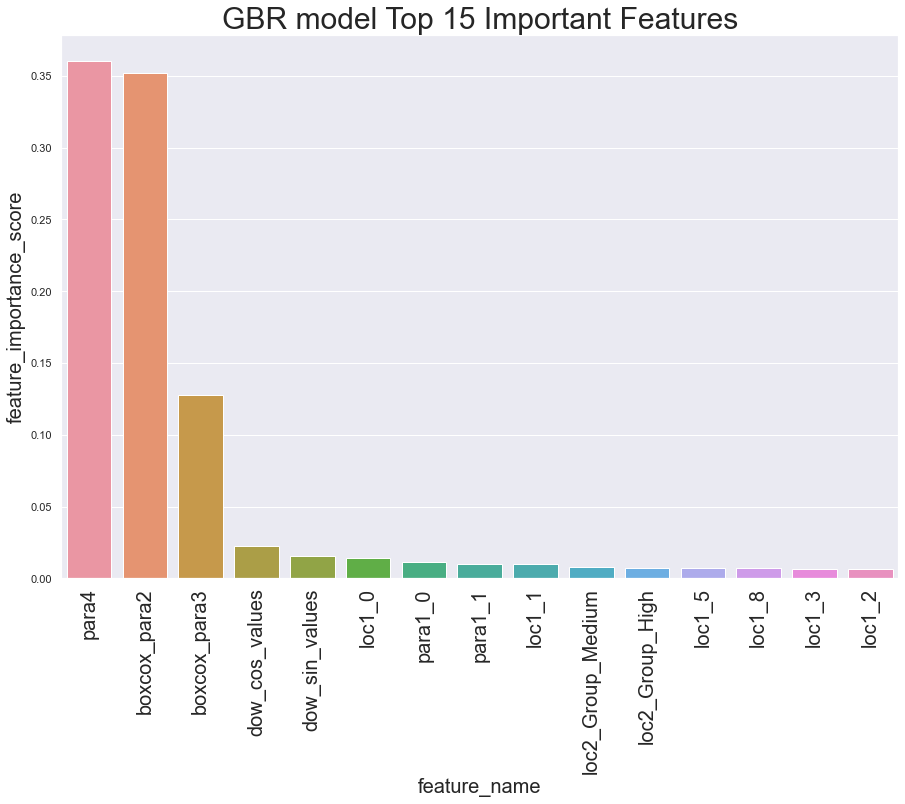

In [141]:
# GBR model
fig, ax = plt.subplots(figsize = (15,10))

plt.title('GBR model Top 15 Important Features', fontsize=30)
sns.barplot(gbr_model_fi_df.feature_name[:15],gbr_model_fi_df.feature_importance_score[:15])

ax.set_xlabel('feature_name',fontsize = 20)
ax.set_ylabel('feature_importance_score',fontsize = 20)

# labels = list(gbr_model_fi_df.feature_name)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize=20)



[Text(0, 0, 'para4'),
 Text(1, 0, 'boxcox_para2'),
 Text(2, 0, 'para1_2'),
 Text(3, 0, 'loc2_Group_High'),
 Text(4, 0, 'para1_0'),
 Text(5, 0, 'boxcox_para3'),
 Text(6, 0, 'para1_5'),
 Text(7, 0, 'loc2_Group_Medium'),
 Text(8, 0, 'loc1_1'),
 Text(9, 0, 'para1_3'),
 Text(10, 0, 'loc1_5'),
 Text(11, 0, 'para1_1'),
 Text(12, 0, 'loc1_3'),
 Text(13, 0, 'para1_4'),
 Text(14, 0, 'loc1_9')]

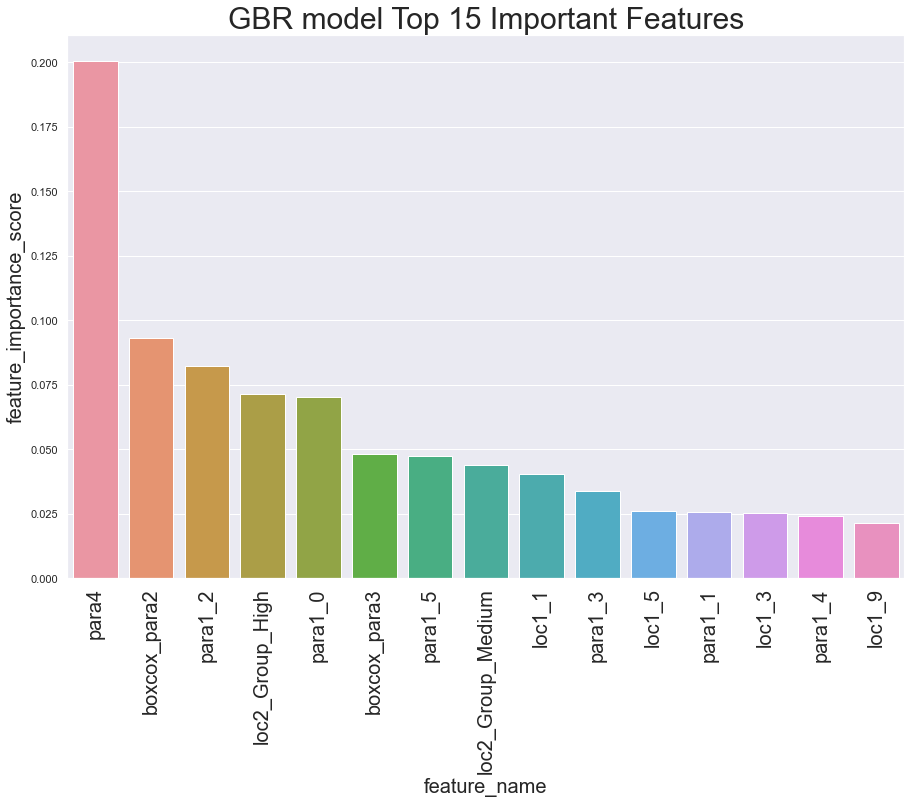

In [143]:
# XGB model
fig, ax = plt.subplots(figsize = (15,10))

plt.title('GBR model Top 15 Important Features', fontsize=30)
sns.barplot(xgb_model_fi_df.feature_name[:15],xgb_model_fi_df.feature_importance_score[:15])

ax.set_xlabel('feature_name',fontsize = 20)
ax.set_ylabel('feature_importance_score',fontsize = 20)

# labels = list(gbr_model_fi_df.feature_name)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize=20)

[Text(0, 0, 'boxcox_para2'),
 Text(1, 0, 'boxcox_para3'),
 Text(2, 0, 'para4'),
 Text(3, 0, 'dow_cos_values'),
 Text(4, 0, 'loc2_Group_High'),
 Text(5, 0, 'para1_0'),
 Text(6, 0, 'loc1_1'),
 Text(7, 0, 'dow_sin_values'),
 Text(8, 0, 'loc1_0'),
 Text(9, 0, 'loc1_5'),
 Text(10, 0, 'loc1_3'),
 Text(11, 0, 'loc1_6'),
 Text(12, 0, 'para1_1'),
 Text(13, 0, 'loc1_2'),
 Text(14, 0, 'para1_2')]

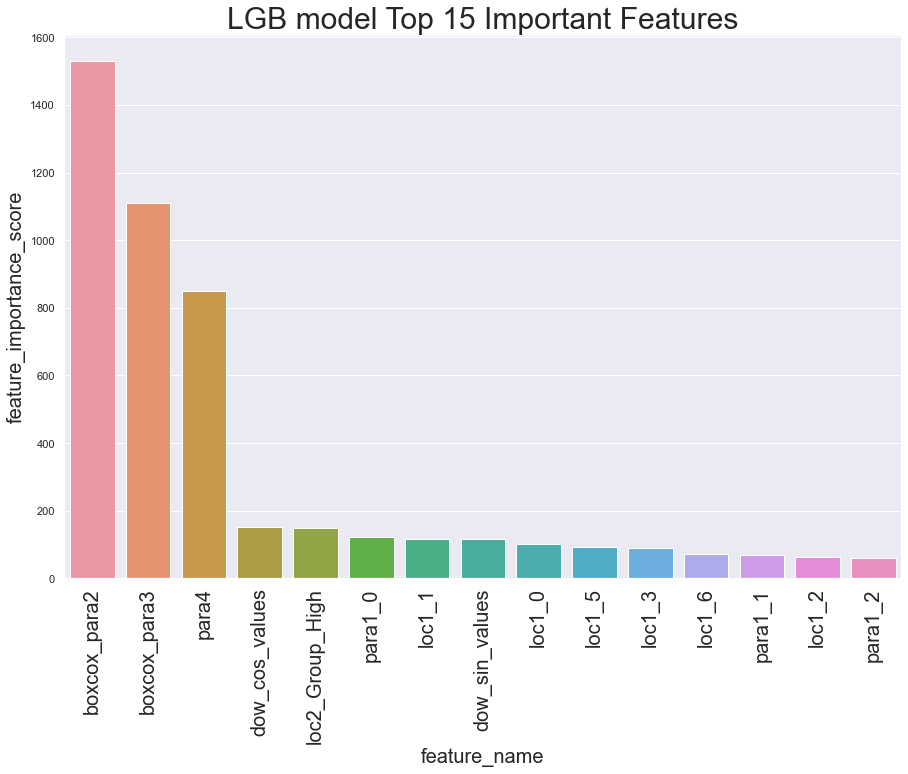

In [144]:
# LGB model
fig, ax = plt.subplots(figsize = (15,10))

plt.title('LGB model Top 15 Important Features', fontsize=30)
sns.barplot(lgb_model_fi_df.feature_name[:15],lgb_model_fi_df.feature_importance_score[:15])


ax.set_xlabel('feature_name',fontsize = 20)
ax.set_ylabel('feature_importance_score',fontsize = 20)

# labels = list(gbr_model_fi_df.feature_name)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, fontsize=20)